In [1]:
import re
import pandas as pd
import numpy as np

from dateutil.parser import parse

import matplotlib.pyplot as plt
import seaborn as sn

import pyspark as spark
import os

os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home'

# Data Imputation

In [92]:
df_raw = pd.read_csv('quotes.csv')
df_raw['Quote'] = pd.eval(df_raw['Quote'])
df_raw.head()

,Tacgia,Link,Namsinh,Quote
0,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"March 14, 1879",[“The world as we have created it is a process...
1,Alexandre Dumas fils,https://quotes.toscrape.com/author/Alexandre-D...,"July 27, 1824",[“The difference between genius and stupidity ...
2,Alfred Tennyson,https://quotes.toscrape.com/author/Alfred-Tenn...,"August 06, 1809",[“If I had a flower for every time I thought o...
3,Allen Saunders,https://quotes.toscrape.com/author/Allen-Saunders,"April 24, 1899",[“Life is what happens to us while we are maki...
4,André Gide,https://quotes.toscrape.com/author/Andre-Gide,"November 22, 1869",[“It is better to be hated for what you are th...


In [93]:
top_birth = df_raw.describe().loc['top', 'Namsinh']

df_raw['Namsinh'] = df_raw['Namsinh'].fillna(top_birth)
df_raw['Namsinh'] = df_raw['Namsinh'].apply(lambda x: parse(x))

In [94]:
df_raw['Tuoi'] = (pd.Timestamp('now') - df_raw['Namsinh']).astype('<m8[Y]')

In [95]:
df_array = []
for i in range(df_raw.shape[0]):
    for j in df_raw.loc[i].Quote:
        new_quote = j[1:-1]
        df_array.append([df_raw.loc[i].Tacgia, df_raw.loc[i].Link, df_raw.loc[i].Namsinh, df_raw.loc[i].Tuoi, new_quote, len(new_quote.split(" "))])

df = pd.DataFrame(df_array, columns=['Tacgia', 'Link', 'Namsinh', 'Tuoi', 'Quote', 'Quote_len'])

In [96]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

In [97]:
df['Tacgia'] = df['Tacgia'].astype('string')
df['Link'] = df['Link'].astype('string')
df['Quote'] = df['Quote'].astype('string')

print(df.dtypes)
df.head()

Tacgia               string
Link                 string
Namsinh      datetime64[ns]
Tuoi                float64
Quote                string
Quote_len             int64
dtype: object


,Tacgia,Link,Namsinh,Tuoi,Quote,Quote_len
0,Mark Twain,https://quotes.toscrape.com/author/Mark-Twain,1835-11-30,185.0,′Classic′ - a book which people praise and don...,10
1,Elie Wiesel,https://quotes.toscrape.com/author/Elie-Wiesel,1928-09-30,93.0,"The opposite of love is not hate, it's indiffe...",37
2,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,1879-03-14,142.0,The world as we have created it is a process o...,21
3,Mark Twain,https://quotes.toscrape.com/author/Mark-Twain,1835-11-30,185.0,Never tell the truth to people who are not wor...,12
4,Charles M. Schulz,https://quotes.toscrape.com/author/Charles-M-S...,1922-11-26,98.0,All you need is love. But a little chocolate n...,14


# Data Exploration

In [113]:
for i in range(df_raw.shape[0]):
    print(f'Author: {df_raw.loc[i].Tacgia:30} Number of quotes: {len(df_raw.loc[i].Quote)}')

Author: Albert Einstein                Number of quotes: 10
Author: Alexandre Dumas fils           Number of quotes: 1
Author: Alfred Tennyson                Number of quotes: 1
Author: Allen Saunders                 Number of quotes: 1
Author: André Gide                     Number of quotes: 1
Author: Ayn Rand                       Number of quotes: 1
Author: Bob Marley                     Number of quotes: 3
Author: C.S. Lewis                     Number of quotes: 5
Author: Charles Bukowski               Number of quotes: 2
Author: Charles M. Schulz              Number of quotes: 1
Author: Douglas Adams                  Number of quotes: 1
Author: Dr. Seuss                      Number of quotes: 6
Author: E.E. Cummings                  Number of quotes: 1
Author: Eleanor Roosevelt              Number of quotes: 2
Author: Elie Wiesel                    Number of quotes: 1
Author: Ernest Hemingway               Number of quotes: 2
Author: Friedrich Nietzsche            Number of quotes

In [115]:
oldest = df[df.Tuoi == df.Tuoi.max()]
youngest = df[df.Tuoi == df.Tuoi.min()]

print('The average age of authors :', df['Tuoi'].describe()['mean'])

print(f'\nThe oldest author: {oldest.iloc[0, 0]}\nDay of birth: {oldest.iloc[0, 2]} ({oldest.iloc[0].Tuoi})')

print(f'\nThe youngest author: {youngest.iloc[0, 0]}\nDay of birth: {youngest.iloc[0, 2]} ({youngest.iloc[0].Tuoi})')

The average age of authors : 121.11

The oldest author: Jane Austen
Day of birth: 1775-12-16 00:00:00 (245.0)

The youngest author: Stephenie Meyer
Day of birth: 1973-12-24 00:00:00 (47.0)


In [119]:
longest = df[df.Quote_len == df.Quote_len.max()]
print('The longest quote(s):')
longest

The longest quote(s):


,Tacgia,Link,Namsinh,Tuoi,Quote,Quote_len
53,Marilyn Monroe,https://quotes.toscrape.com/author/Marilyn-Monroe,1926-06-01,95.0,"This life is what you make it. No matter what,...",201


In [121]:
shortest = df[df.Quote_len == df.Quote_len.min()]
print('The shortest quote(s):')
shortest

The shortest quote(s):


,Tacgia,Link,Namsinh,Tuoi,Quote,Quote_len
18,J.R.R. Tolkien,https://quotes.toscrape.com/author/J-R-R-Tolkien,1892-01-03,129.0,Not all those who wander are lost.,7
23,Stephenie Meyer,https://quotes.toscrape.com/author/Stephenie-M...,1973-12-24,47.0,"He's like a drug for you, Bella.",7
82,William Nicholson,https://quotes.toscrape.com/author/William-Nic...,1948-01-12,73.0,We read to know we're not alone.,7


In [128]:
print('\nOn average, each quote have', df['Quote_len'].describe()['mean'], 'words')


On average, each quote have 23.63 words


In [136]:
words = []
for i in df['Quote']:
    for j in i.split(' '):
        if j != '':
            words.append(j)

words[0:10]

['′Classic′',
 '-',
 'a',
 'book',
 'which',
 'people',
 'praise',
 'and',
 "don't",
 'read.']

In [137]:
%%time
sc = spark.SparkContext.getOrCreate()
words_sc = sc.parallelize(words)

CPU times: user 2.47 ms, sys: 2.07 ms, total: 4.53 ms
Wall time: 5.11 ms


In [140]:
%%time
words_count = words_sc.map(lambda x: (x.lower(), 1)).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1]).collect()

words_count[0:10]

CPU times: user 30.8 ms, sys: 10.8 ms, total: 41.5 ms
Wall time: 383 ms


[('praise', 1),
 ('hate,', 1),
 ('faith', 1),
 ('process', 1),
 ('cannot', 1),
 ('putting', 1),
 ('failed.', 1),
 ('this,', 1),
 ('far', 1),
 ('lost.', 1)]

In [196]:
freq_min = words_count[0][1]
freq_max = words_count[-1][1]
words_min = []
words_max = []

for i in words_count:
    if i[1] == freq_min:
        words_min.append(i[0])
    if i[1] == freq_max:
        words_max.append(i[0])

print(f'The least common word(s): {words_min}\nOccurrence: {freq_min} \nNo.: {len(words_min)}')
print(f'\nThe most common word(s): {words_max}\nOccurrence: {freq_max} \nNo.: {len(words_max)}')

The least common word(s): ['praise', 'hate,', 'faith', 'process', 'cannot', 'putting', 'failed.', 'this,', 'far', 'lost.', 'horrible', 'lead.', 'rather', 'happiness', 'treated', 'sixty', 'stupid', 'misinformed', 'nonsense,', 'head,', 'why', 'real?', 'madly', 'anytime', 'admiration', 'finish', 'spirit', 'unhappy', 'free', 'trouble', 'start', 'question', 'sometimes,', 'girls', "life's", 'like,', 'matters', 'cup', 'sun', 'old,', 'kisses', 'listens', 'yours', 'strayed', 'dead,', 'flower', 'thought', 'you...i', 'follows', 'heart', 'intact', 'one,', 'irredeemable.', 'confirms', 'belief', 'inconsistency', 'thought,', 'attempt', 'not.', 'declare', 'excellent', 'loyal', 'people,', 'impossible', 'default.', 'only.', 'perfect', 'happy,', 'bat.', 'notion', 'education.', 'true.', 'eventually', 'need', 'don’t', 'is:', 'real', 'space.', 'view...', 'knowing', 'how,', 'pride:', 'hand', 'hand,', 'show', 'seem', 'typewriter', "he's", '"it', 'seconds', 'black', 'eye.', 'cells.', 'terms', 'blunders', 'day.

## Relative between authors and quotes

In [ ]:
df_raw['Quote_qty'] = df_raw['Quote'].apply(lambda x: len(x))

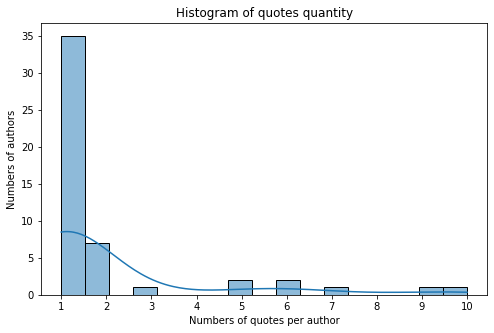

In [195]:
plt.figure(figsize=(8, 5))
sn.histplot(df_raw['Quote_qty'],kde=True)
plt.title('Histogram of quotes quantity')
plt.xlabel('Numbers of quotes per author')
plt.ylabel('Numbers of authors')
plt.xticks(np.arange(1,11,1))
plt.show()

In [193]:
active_author = (df_raw[df_raw['Quote_qty'] >= 4]['Tacgia']).values
print('List of active authors who have more than 4 quotes:')
for i in active_author:
    print('\t-',i)

List of active authors who have more than 4 quotes:
	- Albert Einstein
	- C.S. Lewis
	- Dr. Seuss
	- J.K. Rowling
	- Jane Austen
	- Marilyn Monroe
	- Mark Twain


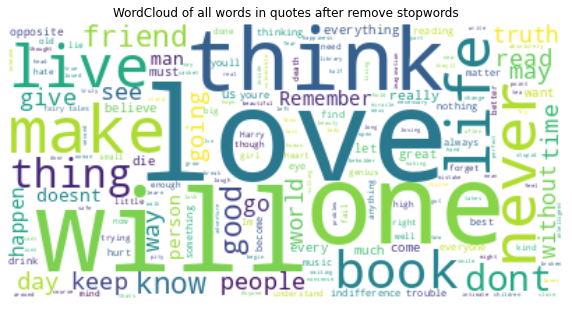

In [209]:
import string
from wordcloud import STOPWORDS, WordCloud

my_stopwords = set(STOPWORDS)
regex = re.compile('[%s]' % re.escape(string.punctuation))
wc = WordCloud(stopwords=my_stopwords, background_color='white').generate(regex.sub('', str(words)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of all words in quotes after remove stopwords')
plt.show()

WordCloud of activiest authors


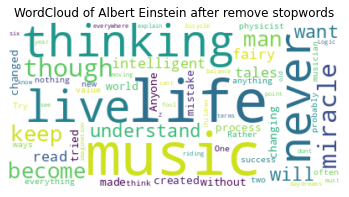

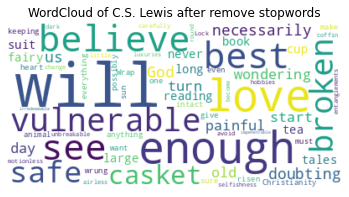

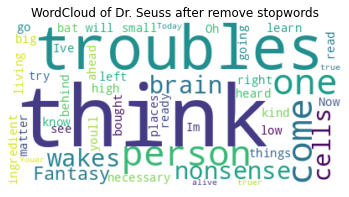

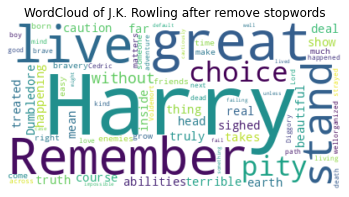

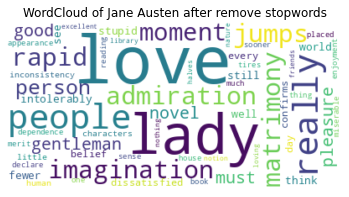

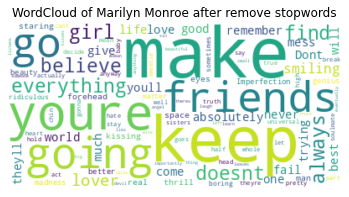

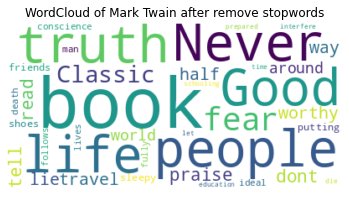

In [218]:
print('WordCloud of activiest authors')
for i in active_author:
    tmp_quotes = []
    for q in df[df['Tacgia'] == i]['Quote']:
        tmp_quotes.append(q)
    tmp_quotes = ' '.join(tmp_quotes)
    wc = WordCloud(stopwords=my_stopwords, background_color='white').generate(regex.sub('', str(tmp_quotes)))
    plt.figure(figsize=(6, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud of '+i+' after remove stopwords')
    plt.show()

## Relative of author with each other

In [215]:
df_raw['Decade'] = df_raw['Namsinh'].apply(lambda x: x.year-(x.year%10))

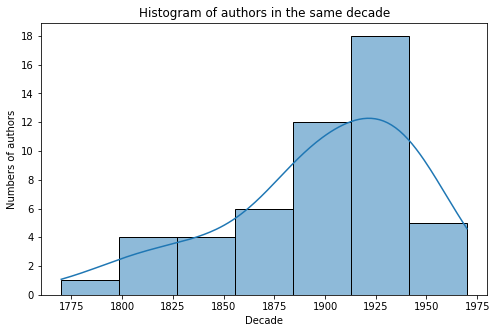

In [222]:
plt.figure(figsize=(8, 5))
plt.title('Histogram of authors in the same decade')
sn.histplot(df_raw['Decade'],kde=True)
plt.yticks(np.arange(0,20,2))
plt.xlabel('Decade')
plt.ylabel('Numbers of authors')
plt.show()

# Feature extraction

In [224]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(df['Quote'])
feature = vectorizer.get_feature_names()
feature

['000',
 '10',
 'abilities',
 'absolutely',
 'absurdities',
 'accept',
 'act',
 'actually',
 'admiration',
 'admit',
 'adventure',
 'ahead',
 'airless',
 'alive',
 'analyze',
 'angel',
 'angry',
 'animal',
 'answers',
 'anytime',
 'appearance',
 'aren',
 'art',
 'asleep',
 'attempt',
 'author',
 'avoid',
 'awfully',
 'baby',
 'bad',
 'bag',
 'balance',
 'bat',
 'battle',
 'beautiful',
 'beauty',
 'begin',
 'beholder',
 'belief',
 'believe',
 'bella',
 'best',
 'better',
 'bicycle',
 'big',
 'black',
 'bleed',
 'blunders',
 'book',
 'books',
 'boring',
 'born',
 'bought',
 'boy',
 'brain',
 'brave',
 'bravery',
 'break',
 'broken',
 'car',
 'carefully',
 'case',
 'casket',
 'cause',
 'caution',
 'cautiously',
 'cedric',
 'celebrate',
 'cells',
 'change',
 'changed',
 'changing',
 'characters',
 'chest',
 'children',
 'chin',
 'chocolate',
 'choice',
 'choices',
 'christian',
 'christianity',
 'church',
 'classic',
 'climb',
 'close',
 'closed',
 'closes',
 'coffin',
 'come',
 'comforted

# Inference

In [232]:
print('Danh sach nhung tac gia co the du doan :')
for i in active_author:
    print('\t-',i)

Danh sach nhung tac gia co the du doan :
	- Albert Einstein
	- C.S. Lewis
	- Dr. Seuss
	- J.K. Rowling
	- Jane Austen
	- Marilyn Monroe
	- Mark Twain


In [249]:
df_inference = pd.DataFrame()
for i in range(df.shape[0]):
    if df.loc[i]['Tacgia'] in active_author:
        temp = {}
        temp['Author'] = df.loc[i]['Tacgia']
        v = CountVectorizer(stop_words='english')

        v.fit([df.loc[i]['Quote']])
        for t in v.get_feature_names():
            if t in temp:
                temp[t] += 1
            else:
                temp[t] = 1

        df_inference = df_inference.append(temp, ignore_index=True)

In [250]:
df_inference.fillna(0,inplace=True)
df_inference.head()

,Author,book,classic,don,people,praise,read,changed,changing,created,...,schooling,alive,today,truer,youer,children,intelligent,eventually,lies,trust
0,Mark Twain,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Albert Einstein,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Mark Twain,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mark Twain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Albert Einstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [251]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
column_names = df_inference.columns.values
for i in range(len(column_names)):
  if df_inference.dtypes[i]=='object':
    df_inference[column_names[i]] = encoder.fit_transform(df_inference[column_names[i]])

In [252]:
X = df_inference.values[:,:-1]
y = df_inference.values[:,-1]

In [253]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [254]:
import tensorflow as tf

model = tf.keras.Sequential([
        tf.keras.layers.Dense(50)
        ])

In [255]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [256]:
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
1/1 [==============================] - 0s 239ms/step - loss: 3.8299 - accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 3ms/step - loss: 3.8042 - accuracy: 0.0312
Epoch 3/30
1/1 [==============================] - 0s 2ms/step - loss: 3.7786 - accuracy: 0.0312
Epoch 4/30
1/1 [==============================] - 0s 3ms/step - loss: 3.7530 - accuracy: 0.0312
Epoch 5/30
1/1 [==============================] - 0s 2ms/step - loss: 3.7274 - accuracy: 0.0312
Epoch 6/30
1/1 [==============================] - 0s 2ms/step - loss: 3.7019 - accuracy: 0.0312

In [257]:
test_loss, test_acc = model.evaluate(X_test,y_test, verbose=2)

print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 3.5164 - accuracy: 0.2500

Test accuracy: 0.25


In [266]:
import spacy

nlp = spacy.load("en_core_web_sm")

df_inference2 = pd.DataFrame()
for i in range(df.shape[0]):
    temp = {}
    temp['Author'] = df.loc[i]['Tacgia']
    temp['Quote'] = df.loc[i]['Quote']
    doc = nlp(df.loc[i]['Quote'])
    temp_pos = []
    for token in doc:
        if token.is_stop == False:
            temp_pos.append(token.pos_)
    temp['POSes'] = ' '.join(temp_pos)

    df_inference2 = df_inference2.append(temp, ignore_index=True)

In [267]:
df_inference2.head()

,Author,POSes,Quote
0,Mark Twain,NOUN PUNCT NOUN NOUN VERB VERB PUNCT,′Classic′ - a book which people praise and don...
1,Elie Wiesel,NOUN NOUN NOUN PUNCT NOUN PUNCT NOUN NOUN ADJ ...,"The opposite of love is not hate, it's indiffe..."
2,Albert Einstein,NOUN VERB NOUN NOUN PUNCT VERB VERB NOUN PUNCT,The world as we have created it is a process o...
3,Mark Twain,VERB NOUN NOUN ADJ PUNCT,Never tell the truth to people who are not wor...
4,Charles M. Schulz,VERB NOUN PUNCT ADJ NOUN VERB PUNCT,All you need is love. But a little chocolate n...


In [268]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")]
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [269]:
df_inference2['trigram'] = df_inference2['POSes'].apply(lambda x: generate_N_grams(x,3))

In [270]:
df_inference2.head()

,Author,POSes,Quote,trigram
0,Mark Twain,NOUN PUNCT NOUN NOUN VERB VERB PUNCT,′Classic′ - a book which people praise and don...,"[NOUN PUNCT NOUN, PUNCT NOUN NOUN, NOUN NOUN V..."
1,Elie Wiesel,NOUN NOUN NOUN PUNCT NOUN PUNCT NOUN NOUN ADJ ...,"The opposite of love is not hate, it's indiffe...","[NOUN NOUN NOUN, NOUN NOUN PUNCT, NOUN PUNCT N..."
2,Albert Einstein,NOUN VERB NOUN NOUN PUNCT VERB VERB NOUN PUNCT,The world as we have created it is a process o...,"[NOUN VERB NOUN, VERB NOUN NOUN, NOUN NOUN PUN..."
3,Mark Twain,VERB NOUN NOUN ADJ PUNCT,Never tell the truth to people who are not wor...,"[VERB NOUN NOUN, NOUN NOUN ADJ, NOUN ADJ PUNCT]"
4,Charles M. Schulz,VERB NOUN PUNCT ADJ NOUN VERB PUNCT,All you need is love. But a little chocolate n...,"[VERB NOUN PUNCT, NOUN PUNCT ADJ, PUNCT ADJ NO..."


In [278]:
df_inference3 = df_inference2.groupby('Author')['trigram'].apply(list).reset_index()
df_inference3.head()

,Author,trigram
0,Albert Einstein,"[[NOUN VERB NOUN, VERB NOUN NOUN, NOUN NOUN PU..."
1,Alexandre Dumas fils,"[[NOUN NOUN NOUN, NOUN NOUN PUNCT, NOUN PUNCT ..."
2,Alfred Tennyson,"[[NOUN NOUN VERB, NOUN VERB PUNCT, VERB PUNCT ..."
3,Allen Saunders,"[[NOUN VERB VERB, VERB VERB NOUN, VERB NOUN PU..."
4,André Gide,"[[ADJ VERB VERB, VERB VERB PUNCT]]"


In [279]:
df_corr = pd.DataFrame([],columns=df_inference3['Author'],index=df_inference3['Author'])
df_corr

Author,Albert Einstein,Alexandre Dumas fils,Alfred Tennyson,Allen Saunders,André Gide,Ayn Rand,Bob Marley,C.S. Lewis,Charles Bukowski,Charles M. Schulz,...,Mother Teresa,Pablo Neruda,Ralph Waldo Emerson,Stephenie Meyer,Steve Martin,Suzanne Collins,Terry Pratchett,Thomas A. Edison,W.C. Fields,William Nicholson
Author,,,,,,,,,,,,,,,,,,,,,
Albert Einstein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alexandre Dumas fils,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alfred Tennyson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Allen Saunders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
André Gide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ayn Rand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bob Marley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C.S. Lewis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Charles Bukowski,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [284]:
for i in range(0,df_inference3.shape[0]):
    temp1 = df_inference3.iloc[i]['trigram']
    for j in range(i+1,df_inference3.shape[0]):
        temp2 = df_inference3.iloc[j]['trigram']
        count = 0
        for a in temp1:
            for b in temp2:
                for t in a:
                    if t in b:
                        count +=1
        df_corr[df_inference3.iloc[i]['Author']][df_inference3.iloc[j]['Author']] = count

In [286]:
df_corr = df_corr.fillna(0)
df_corr

Author,Albert Einstein,Alexandre Dumas fils,Alfred Tennyson,Allen Saunders,André Gide,Ayn Rand,Bob Marley,C.S. Lewis,Charles Bukowski,Charles M. Schulz,...,Mother Teresa,Pablo Neruda,Ralph Waldo Emerson,Stephenie Meyer,Steve Martin,Suzanne Collins,Terry Pratchett,Thomas A. Edison,W.C. Fields,William Nicholson
Author,,,,,,,,,,,,,,,,,,,,,
Albert Einstein,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alexandre Dumas fils,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alfred Tennyson,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Allen Saunders,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
André Gide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ayn Rand,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bob Marley,72,4,5,3,2,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C.S. Lewis,62,6,3,2,1,1,49,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charles Bukowski,31,2,4,2,2,4,43,21,0,0,...,0,0,0,0,0,0,0,0,0,0


In [297]:
for i in range(df_corr.shape[0]):
    print('Compare ',df_inference3.iloc[i]['Author'],'with: ')
    print(df_corr.sort_values(df_inference3.iloc[i]['Author'],ascending=False)[df_inference3.iloc[i]['Author']].nlargest(10))
    print('\n\n')

Compare  Albert Einstein with: 
Author
Jane Austen           111
J.K. Rowling           88
Dr. Seuss              82
Marilyn Monroe         80
Bob Marley             72
C.S. Lewis             62
Mark Twain             55
George R.R. Martin     31
Charles Bukowski       31
Pablo Neruda           26
Name: Albert Einstein, dtype: int64



Compare  Alexandre Dumas fils with: 
Author
Jane Austen            17
Marilyn Monroe          9
Dr. Seuss               7
C.S. Lewis              6
Mark Twain              6
Elie Wiesel             5
Friedrich Nietzsche     4
James Baldwin           4
Bob Marley              4
Pablo Neruda            4
Name: Alexandre Dumas fils, dtype: int64



Compare  Alfred Tennyson with: 
Author
Marilyn Monroe        10
J.K. Rowling           8
Dr. Seuss              5
Bob Marley             5
Charles Bukowski       4
Mark Twain             3
Jimi Hendrix           3
Jane Austen            3
George R.R. Martin     3
J.D. Salinger          3
Name: Alfred Tennyson, dt